# Benoit's Problem with various RTO Algorithms

In [199]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import approx_fprime
import matplotlib.pyplot as plt

# 0. Benoit's Problem

In [200]:

# Actual Plant System
def Benoit_System_1(u):
    f = u[0] ** 2 + u[1] ** 2 + u[0] * u[1] + np.random.normal(0., np.sqrt(1e-3))
    return f

def Benoit_System_2(u):
    f = u[0] ** 2 + u[1] ** 2 + (1 - u[0] * u[1])**2 + np.random.normal(0., np.sqrt(1e-3))
    return f


def con1_system(u):
    g1 = 1. - u[0] + u[1] ** 2 + 2. * u[1] - 2. + np.random.normal(0., np.sqrt(1e-3))
    return -g1


def con1_system_tight(u):
    g1 = 1. - u[0] + u[1] ** 2 + 2. * u[1] + np.random.normal(0., np.sqrt(1e-3))
    return -g1


def Benoit_System_noiseless_1(u):
    f = u[0] ** 2 + u[1] ** 2 + u[0] * u[1]   # + np.random.normal(0., np.sqrt(1e-3))
    return f

def Benoit_System_noiseless_2(u):
    f = u[0] ** 2 + u[1] ** 2 + (1 - u[0] * u[1])**2  # + np.random.normal(0., np.sqrt(1e-3))
    return f


def con1_system_noiseless(u):
    g1 = 1. - u[0] + u[1] ** 2 + 2. * u[1] - 2.  # + np.random.normal(0., np.sqrt(1e-3))
    return -g1

def con1_system_tight_noiseless(u):
    g1 = 1. - u[0] + u[1] ** 2 + 2. * u[1]  # + np.random.normal(0., np.sqrt(1e-3))
    return -g1

## Diagram for Benoit's Problem

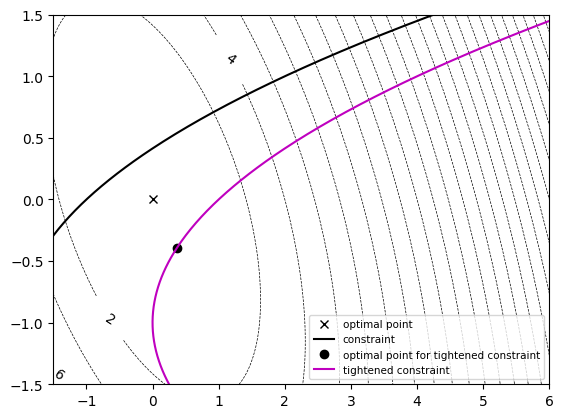

In [201]:
# Plot for objective function 
def plant_drawing(is_constraint,is_tight_constraint):
        delta = 0.01
        x = np.arange(-6.5, 6.5, delta)
        y = np.arange(-6.5, 6.5, delta)
        u = np.meshgrid(x, y)
        levels = np.linspace(0,50,26)

        CS1 = plt.contour(u[0],u[1],Benoit_System_noiseless_1(u),levels,colors='k',linestyles = "dashed",linewidths = 0.5)
        plt.clabel(CS1,inline=True)
        plt.axis((-1.5, 6.0, -1.5, 1.5))

        if is_constraint == True:
                # Plot for optimal value for optimization with constraint
                u0 = [2,1] 
                con = ({'type': 'ineq', 
                        'fun': lambda u: con1_system_noiseless(u)}) 
                result = minimize(Benoit_System_noiseless_1,
                                u0,
                                constraints= con,
                                method='SLSQP',
                                options={'ftol': 1e-9})
                
                ustar = result.x
                fstar = result.fun
                plt.plot(ustar[0],ustar[1],'kx')
                
                # Plot for constraint
                uc0 = 1. + x ** 2 + 2. * x - 2.
                constraint1 = plt.plot(uc0,x,'k')

        if is_tight_constraint == True:

                # Plot for optimal value for optimization with tightened constraint
                u0 = [2,1] 
                con = ({'type': 'ineq', 
                        'fun': lambda u: con1_system_tight_noiseless(u)}) 
                result_tight = minimize(Benoit_System_noiseless_1,
                                u0,
                                constraints= con,
                                method='SLSQP',
                                options={'ftol': 1e-9})

                ustar = result_tight.x
                fstar = result_tight.fun
                plt.plot(ustar[0],ustar[1],'ko')

                # Plot for tightened constraint

                uc0t = 1. + x ** 2 + 2. * x
                constraint2 = plt.plot(uc0t,x,'m')

# plant_drawing(is_constraint=True,is_tight_constraint=False)
plant_drawing(is_constraint=True,is_tight_constraint=True)
plt.legend(["optimal point",
            "constraint",
            'optimal point for tightened constraint',
            'tightened constraint'],
                fontsize = 7.5)
plt.show()

# 1. Modifier Adaptation

## A. Benoit Model

In [202]:
# Plant Model 
def Benoit_Model(u,u0,theta,modifier):

    f = theta[0] * u[0] ** 2 + theta[1] * u[1] ** 2 + modifier[0]*(u[0]) + modifier[1]*(u[1])
    return f

def con1_model(u,u0,theta,modifier):

    g1 = 1. - theta[2]*u[0] + theta[3]*u[1] ** 2 + modifier[2] + modifier[3]*(u[0]-u0[0]) + modifier[4]*(u[1]-u0[1])
    return -g1


## B. Optimization on Cost Function

In [203]:
def cost_optimize(u0,theta,modifier):

    con = ({'type': 'ineq',
            'fun': lambda u: con1_model(u,u0,theta,modifier)})
    
    result = minimize((Benoit_Model),
                    u0,
                    constraints= con,
                    method='SLSQP',
                    options= {'ftol': 1e-9},
                    args= (u0,theta,modifier))
    
    return result.x,result.fun

In [204]:
# # Test
# u0 = [1,1] # Initial guess for optimization algorithm
# modifier = [1,1,1,1,1]
# theta = [0.5,0.5,0.5,0.5]

# u,fun = cost_optimize(u0,theta,modifier)

# print(f"optimal input: {u}, optimal output: {fun}")

## C. Modifier Adaptation

In [205]:
# gradient modifier
def gradient_estimation(u,fun):
    # step
    du = np.sqrt(1e-10) # np.finfo
    u = np.array(u)
    # Predicted gradient from real plant
    gradient_u0 = (fun(u+[du,0]) - fun(u))/du
    gradient_u1 = (fun(u+[0,du]) - fun(u))/du
    gradient = [gradient_u0,gradient_u1]
    
    return gradient

# Modifier Update
def modifier_update(u,u0,theta,modifier,plant_fun,plant_con1):
    
    # Calculate relavent bias and gradients:
    gradient_cost_p = gradient_estimation(u,plant_fun)
    ## Gradient of plant constraint function
    gradient_con1_p = gradient_estimation(u,plant_con1)
    ## Gradient of model cost function
    gradient_cost_m = approx_fprime(u,Benoit_Model,np.sqrt(1e-10),u0,theta,modifier)
    ## Gradient of model constraint function
    gradient_con1_m = approx_fprime(u,con1_model,np.sqrt(1e-10),u0,theta,modifier)
    ## Gradient of plant cost function

    # Calculate difference between plant and model
    lamda_0 = gradient_cost_p - gradient_cost_m
    epsil = -(plant_con1(u) - con1_model(u,u0,theta,modifier))
    lamda_1 = -1*(gradient_con1_p - gradient_con1_m)
    
    return [lamda_0[0],lamda_0[1],epsil,lamda_1[0],lamda_1[1]]

# Modifier Adaptation
def adaptation(u,u0,theta,modifier,plant_fun,plant_con1,K):
    new_modifier = modifier_update(u,u0,theta,modifier,plant_fun,plant_con1)
    I = np.identity(len(modifier))

    for i in range(len(modifier)):
        modifier[i] = (I - K)[i,i]*modifier[i] + K[i,i]*new_modifier[i]

    return modifier

In [206]:
# # Test
# ## Variable
# u = [-0.20316229, -0.80316225]
# u0 = [-1,-1]
# modifier = [1,1,1,1,1]
# theta = [0.5,0.5,0.5,0.5]
# plant_fun = Benoit_System_noiseless_1
# plant_con1 = con1_system_tight_noiseless
# K = np.identity(len(modifier))*0.2

# # Modifier Adaptation
# modifier = adaptation(u,u0,theta,modifier,plant_fun,plant_con1,K)
# print(f"New Modifier: {modifier}")

## D. Overall Algorithm

### I.Plant System 1: 
- "Benoit_System_noiseless_1"
- "con1_system_noiseless" constraint

In [207]:
# Initial Guess (k=0)
uk = [2,-1]
modifierk = [1,1,1,1,1]
theta = [0.5,0.5,0.5,0.5]
plant_fun = Benoit_System_noiseless_1
plant_con1 = con1_system_noiseless
K = np.identity(len(modifierk))*0.19

# Dictionary for data collection 
data = {}
data['index'] = [0]
data['u_0'] = [uk[0]]
data['u_1'] = [uk[1]]
data['modifiers'] = []
for i in modifierk:
    data['modifiers'].append([i])
data['cost'] = [Benoit_Model(u=uk,u0=uk,theta=theta,modifier=modifierk)]

# Algorithm
for i in range(100):
    uk_1,fun = cost_optimize(uk,theta,modifierk)
    modifierk_1 = adaptation(uk_1,uk,theta,modifierk,plant_fun,plant_con1,K)

    uk = uk_1
    modifierk = modifierk_1

    # Collecting data
    data['index'].append(i+1)
    data['u_0'].append(uk[0]), data['u_1'].append(uk[1])
    for i in range(len(modifierk)):
        data['modifiers'][i].append(modifierk[i])
    data['cost'].append(fun) 

### II Result

#### i. Trace of optimal inputs made by Modifier Adaptation Algorithm

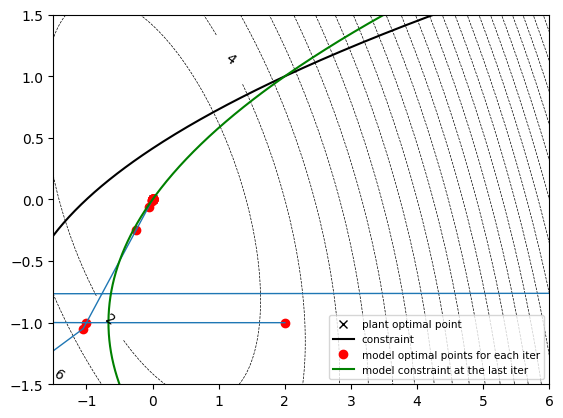

In [208]:
plant_drawing(is_constraint=True,is_tight_constraint=False)
plt.plot(data['u_0'],data['u_1'], 'ro',)
plt.plot(data['u_0'],data['u_1'], linestyle='-',linewidth=1,label='_nolegend_')
delta = 0.01
uc1 = np.arange(-2.5, 6.5, delta)
uc0 = (theta[3]*uc1**2 + data['modifiers'][2][-1] - data['modifiers'][3][-1]*data['u_0'][-1] 
       + data['modifiers'][4][-1]*(uc1-data['u_1'][-1]) + 1)/(theta[2] - data['modifiers'][3][-1])
plt.plot(uc0,uc1,'g')

plt.legend(["plant optimal point",
            "constraint",
            'model optimal points for each iter',
            'model constraint at the last iter'],
                fontsize = 7.5)

plt.show()

#### ii. Cost Function through 5 iterations

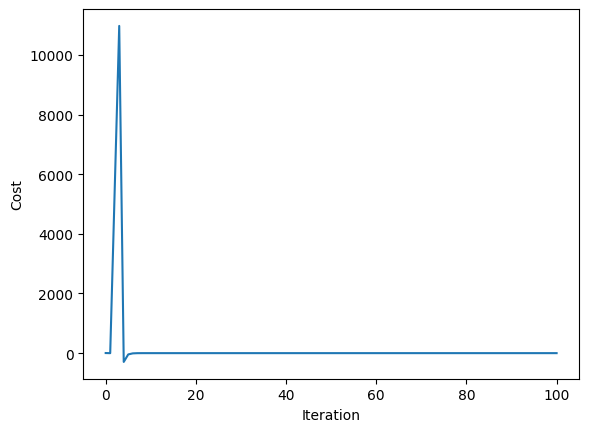

In [209]:
plt.plot(data['index'],data['cost'])
plt.xlabel('Iteration'), plt.ylabel('Cost')
plt.show()

#### iii. Modifiers of model through 5 iterations

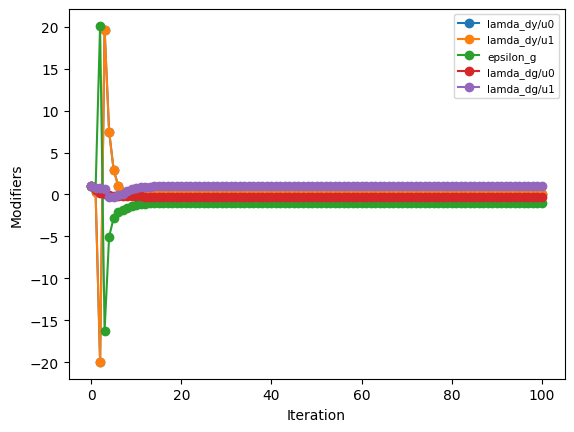

In [210]:
plt.plot(data['index'],
         data['modifiers'][0],
         data['index'],
         data['modifiers'][1],
         data['index'],
         data['modifiers'][2],
         data['index'],
         data['modifiers'][3],
         data['index'],
         data['modifiers'][4],
         marker='o')
plt.legend(["lamda_dy/u0",
            "lamda_dy/u1",
            "epsilon_g",
            "lamda_dg/u0",
            "lamda_dg/u1"],
            fontsize = 7.5)
plt.xlabel("Iteration"), plt.ylabel("Modifiers")
plt.show()

### III.Plant System_2: 
- "Benoit_System_noiseless_1", 
- "con1_system_tight_noiseless" constraint

In [211]:
# Initial Guess (k=0)
uk = [2,-1]
modifierk = [1,1,1,1,1]
theta = [1.5,1,1.5,1]
plant_fun = Benoit_System_noiseless_1
plant_con1 = con1_system_tight_noiseless
K = np.identity(len(modifierk))*0.1

# Dictionary for data collection 
data = {}
data['index'] = [0]
data['u_0'] = [uk[0]]
data['u_1'] = [uk[1]]
data['modifiers'] = []
for i in modifierk:
    data['modifiers'].append([i])
data['cost'] = [Benoit_Model(u=uk,u0=uk,theta=theta,modifier=modifierk)]

# Algorithm
for i in range(10):
    uk_1,fun = cost_optimize(uk,theta,modifierk)
    modifierk_1 = adaptation(uk_1,uk,theta,modifierk,plant_fun,plant_con1,K)

    uk = uk_1
    modifierk = modifierk_1

    # Collecting data
    data['index'].append(i+1)
    data['u_0'].append(uk[0]), data['u_1'].append(uk[1])
    for i in range(len(modifierk)):
        data['modifiers'][i].append(modifierk[i])
    data['cost'].append(fun) 

### IV Result

#### i. Trace of optimal inputs made by Modifier Adaptation Algorithm

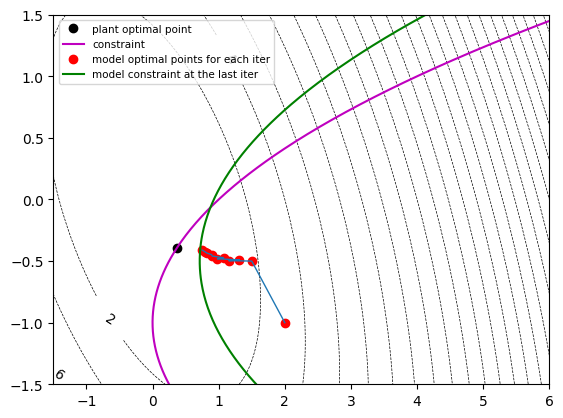

-0.07836709461504096 0.330530636799414 1.0000000000002347 0.7500261457216366 -0.41015879915673603


In [212]:
plant_drawing(is_constraint=False,is_tight_constraint=True)
plt.plot(data['u_0'],data['u_1'], 'ro',)
plt.plot(data['u_0'],data['u_1'], linestyle='-',linewidth=1,label='_nolegend_')
delta = 0.01
uc1 = np.arange(-2.5, 6.5, delta)
uc0 = (theta[3]*uc1**2 + data['modifiers'][2][-1] - data['modifiers'][3][-1]*data['u_0'][-1] 
       + data['modifiers'][4][-1]*(uc1-data['u_1'][-1]) + 1)/(theta[2] - data['modifiers'][3][-1])
plt.plot(uc0,uc1,'g')
plt.legend(["plant optimal point",
            "constraint",
            'model optimal points for each iter',
            'model constraint at the last iter'],
                fontsize = 7.5)
plt.show()

print(data['modifiers'][2][-1],data['modifiers'][3][-1],data['modifiers'][4][-1],data['u_0'][-1],data['u_1'][-1])

#### ii. Cost Function through 5 iterations

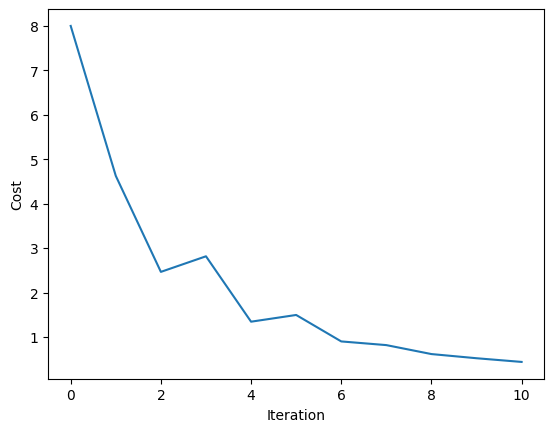

In [213]:
plt.plot(data['index'],data['cost'])
plt.xlabel('Iteration'), plt.ylabel('Cost')
plt.show()

#### iii. Modifiers of model through 5 iterations

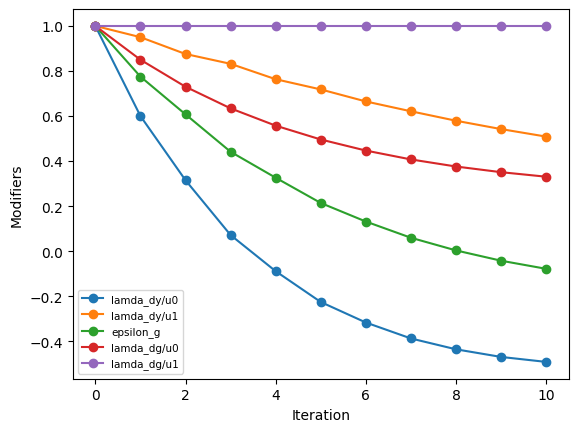

In [214]:
plt.plot(data['index'],
         data['modifiers'][0],
         data['index'],
         data['modifiers'][1],
         data['index'],
         data['modifiers'][2],
         data['index'],
         data['modifiers'][3],
         data['index'],
         data['modifiers'][4],
         marker='o')
plt.legend(["lamda_dy/u0",
            "lamda_dy/u1",
            "epsilon_g",
            "lamda_dg/u0",
            "lamda_dg/u1"],
            fontsize = 7.5)
plt.xlabel("Iteration"), plt.ylabel("Modifiers")
plt.show()

# 2. Setting Initial Values for Parameters by sampling

Values of parameters in the model is not changed in this algorithm. Also, better the initial values of parameters, better the performance of the algorithms. Therefore, setting a good initial values for parameters is vital, which is done in this section.

## Sampling and finding initial values for parameters

In [215]:
A = np.random.rand(40, 2) + 0.5

b = [Benoit_System_noiseless_1(i) for i in A]
b_g = [con1_system_tight_noiseless(i) for i in A]

x, residuals, rank, singular_values = np.linalg.lstsq(A, b, rcond=None)
x_g, residuals, rank, singular_values = np.linalg.lstsq(A, b_g, rcond=None)
theta_0 = np.concatenate((x, x_g))

print(theta_0)

[ 1.52056256  1.82263892  0.95887846 -4.04430887]


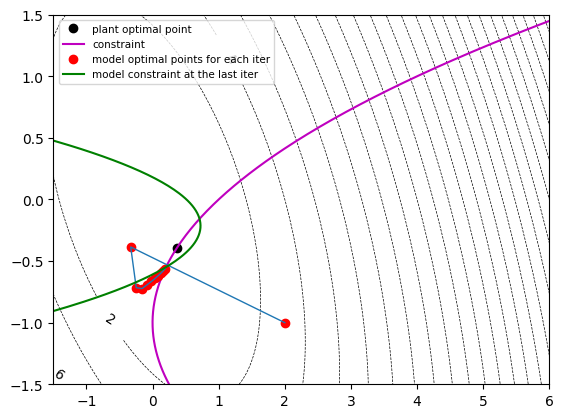

In [216]:
# Initial Guess (k=0)
uk = [2,-1]
modifierk = [1,1,1,1,1]
theta = theta_0
plant_fun = Benoit_System_noiseless_1
plant_con1 = con1_system_tight_noiseless
K = np.identity(len(modifierk))*0.1

# Dictionary for data collection 
data = {}
data['index'] = [0]
data['u_0'] = [uk[0]]
data['u_1'] = [uk[1]]
data['modifiers'] = []
for i in modifierk:
    data['modifiers'].append([i])
data['cost'] = [Benoit_Model(u=uk,u0=uk,theta=theta,modifier=modifierk)]

# Algorithm
for i in range(10):
    uk_1,fun = cost_optimize(uk,theta,modifierk)
    modifierk_1 = adaptation(uk_1,uk,theta,modifierk,plant_fun,plant_con1,K)

    uk = uk_1
    modifierk = modifierk_1

    # Collecting data
    data['index'].append(i+1)
    data['u_0'].append(uk[0]), data['u_1'].append(uk[1])
    for i in range(len(modifierk)):
        data['modifiers'][i].append(modifierk[i])
    data['cost'].append(fun) 

plant_drawing(is_constraint=False,is_tight_constraint=True)
plt.plot(data['u_0'],data['u_1'], 'ro',)
plt.plot(data['u_0'],data['u_1'], linestyle='-',linewidth=1,label='_nolegend_')
delta = 0.01
uc1 = np.arange(-2.5, 6.5, delta)
uc0 = (theta[3]*uc1**2 + data['modifiers'][2][-1] - data['modifiers'][3][-1]*data['u_0'][-1] 
       + data['modifiers'][4][-1]*(uc1-data['u_1'][-1]) + 1)/(theta[2] - data['modifiers'][3][-1])
plt.plot(uc0,uc1,'g')
plt.legend(["plant optimal point",
            "constraint",
            'model optimal points for each iter',
            'model constraint at the last iter'],
                fontsize = 7.5)
plt.show()